In [5]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

import sys
sys.path.append('../')
from src import datasets, metrics

In [6]:
trainfile = Path('../data/heart_train.parq').resolve()
testfile = Path('../data/heart_test.parq').resolve()
# trainfile = Path('../data/heart_big_train.parq').resolve()
# testfile = Path('../data/heart_big_test.parq').resolve()
trainfile, testfile

(PosixPath('/home/azureuser/code/nickyvanoorschot_mads_exam_24/data/heart_train.parq'),
 PosixPath('/home/azureuser/code/nickyvanoorschot_mads_exam_24/data/heart_test.parq'))

Get the 1D data into a 2D matrix

In [7]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"

traindataset.to(device)
testdataset.to(device)


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(1))

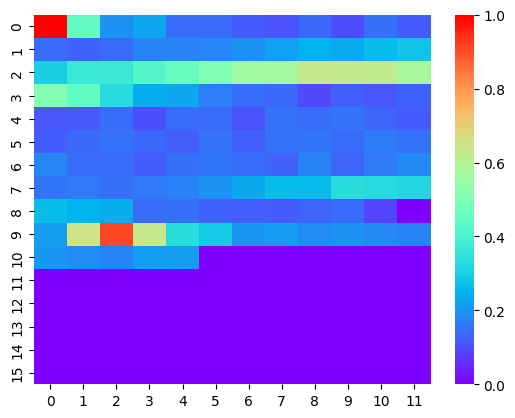

In [8]:
x, y = traindataset[0]
# Assuming your tensor is named 'tensor'
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [9]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(363, 90)

In [10]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

The ConvBlock makes it easier to stack block in the model.
Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, etc.
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
        self.normalization = nn.LayerNorm(out_channels)
        
    def forward(self, x):
        identity = x.clone()
        x = self.conv(x)
        x = self.normalization(x + identity)
        return 

In [22]:
import torch
class CNN(nn.Module):
    def __init__(self, config: dict) -> None:
        super().__init__()
        hidden = config['hidden']
        self.convolutions = nn.ModuleList([
            ConvBlock(1, hidden),
        ])

        for i in range(config['num_layers']):
            self.convolutions.extend([ConvBlock(hidden, hidden), nn.ReLU()])
        self.convolutions.append(nn.MaxPool2d(2, 2))

        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear((8*6) * hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, config['num_classes']),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for conv in self.convolutions:
            x = conv(x)
        x = self.dense(x)
        return x

In [25]:
from src import models
config = {
    'hidden' : 16,
    'num_layers' : 2,
    'num_classes' : 2, 
    'shape' : shape,

}
model = models.CNN(config)
model.to(device)
model(x).shape

2024-06-21 22:42:52.003 | INFO     | src.models:__init__:37 - Activation map size: 48
2024-06-21 22:42:52.003 | INFO     | src.models:__init__:38 - Input linear: 768


torch.Size([32, 2])

In [26]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [27]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [28]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("2D conv model")

<Experiment: artifact_location='/home/azureuser/code/nickyvanoorschot_mads_exam_24/notebooks/mlruns/1', creation_time=1718731675545, experiment_id='1', last_update_time=1718731675545, lifecycle_stage='active', name='2D conv model', tags={}>

In [30]:
from mltrainer import Trainer, TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=10,
        metrics=[recall, accuracy, f1micro, f1macro, precision],
        logdir="heart2D",
        train_steps=len(trainstreamer),
        valid_steps=len(teststreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2024-06-21 22:43:37.378 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to heart2D/20240621-224337
100%|██████████| 363/363 [00:03<00:00, 119.62it/s]
2024-06-21 22:43:41.315 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.2510 test 0.2122 metric ['0.9083', '0.9139', '0.9139', '0.8916', '0.9139']
100%|██████████| 363/363 [00:02<00:00, 124.39it/s]
2024-06-21 22:43:45.128 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2096 test 0.1714 metric ['0.9118', '0.9292', '0.9292', '0.9055', '0.9292']
100%|██████████| 363/363 [00:03<00:00, 118.01it/s]
2024-06-21 22:43:49.081 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1829 test 0.1584 metric ['0.9073', '0.9378', '0.9378', '0.9150', '0.9378']
100%|██████████| 363/363 [00:03<00:00, 102.77it/s]
2024-06-21 22:43:53.495 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1591 test 0.1395 metric ['0.9350', '0.9462', '0.9462', '0.9286', '0.9462']
100%|██████████| 363/363 [00:07<00:00, 48.41it/

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

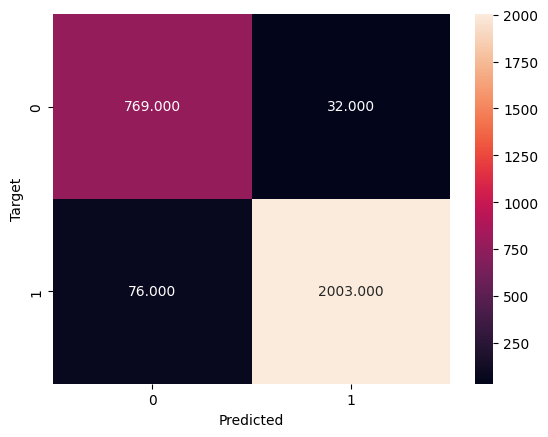

In [56]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
# cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

# Improvement for Recall

The assignment states that the model does work pretty well, but that we rather have a higher recall. In the above deliverd confusion matrix the around 100 á 130 samples were missed and predicted as normal sample. As a first step, I redid the above evaluation and used a threshold rather than the argmax function, therefore a sample is more easily labeled as abnormal, but thats fine. 

using a other model in the next step, we could go for a higher precision. Thanks to our junior college, we have the first sweep!


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual')]

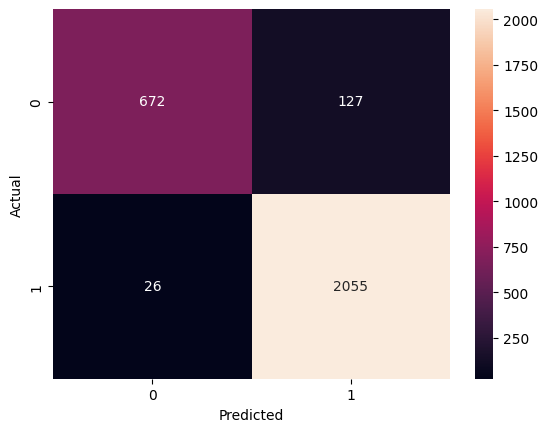

In [58]:
# After training, adjust the threshold during evaluation
threshold = 0.1
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    with torch.no_grad():
        yhat = model(X)
        yhat_probs = torch.softmax(yhat, dim=1)  # Convert logits to probabilities

    yhat_binary = (yhat_probs[:, 1] > threshold).int()

    y_pred.append(yhat_binary.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat_flat = [item for sublist in y_pred for item in sublist]
y_flat = [item for sublist in y_true for item in sublist]

cfm = confusion_matrix(y_flat, yhat_flat)
plot = sns.heatmap(cfm, annot=True, fmt="d")
plot.set(xlabel="Predicted", ylabel="Actual")


In [41]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# After training, adjust the threshold during evaluation
threshold = 0.1
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    with torch.no_grad():
        yhat = model(X)
        yhat_probs = torch.softmax(yhat, dim=1)  # Convert logits to probabilities

    yhat_binary = (yhat_probs[:, 1] > threshold).int()  # Use threshold to get binary predictions

    y_pred.extend(yhat_binary.cpu().tolist())
    y_true.extend(y.cpu().tolist())

recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

Recall: 0.9875
Precision: 0.9414
F1 Score: 0.9639
